In [1]:
import gym #ambiente de prueba
import math 
import torch
import random

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from IPython import display
from itertools import count
from collections import namedtuple


%matplotlib inline

# guardamos el comportamiento para que sea replicable
RANDOM_SEED = 666
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [2]:
# arquitectura de la red neuronal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# ambiente que utilizaremos
# la documentación del ambiente https://gym.openai.com/envs/MountainCar-v0/
env = gym.make('MountainCar-v0')
env.seed(RANDOM_SEED)
env.action_space.seed(RANDOM_SEED)

[666]

In [4]:
# creamos una red que contendrá la politica y 
# otra red que servirá como target, las dos 
# son iguales en arquitectura pero varían en la frecuencia que serán actualizadas.
# la red policy será actualizada en cada paso, la otra red luego de un número 
# determinado de epochs.
policy_net = Net()
target_net = Net()

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    '''Esta es la estructura donde se almacenará los pasos
       que se ejecuten en el ambiente.'''
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [6]:
learning_rate = 5e-2
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [7]:
steps_done = 0
n_actions = 3
episode_durations = []

BATCH_SIZE = 2048
GAMMA = 0.995
EPS_START = 0.99
EPS_END = 0.1
EPS_DECAY = 300
TARGET_UPDATE = 25

In [8]:
#capacidad de la memoria
memory = ReplayMemory(20000)

In [9]:
def seleccionar_accion(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Calcula V(s_{t+1}) para todos los estados siguientes.
    # mayor detalle de la implementación puede ser encontrado en:
    # https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.item()

In [11]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(reward_t, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Se toma el promedio de la duración de los ultimos 100 episodios y se grafica.
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.repeat_interleave(means[0], 99), means))
        plt.plot(means.numpy())
    plt.pause(0.01) 
    display.clear_output(wait=True)

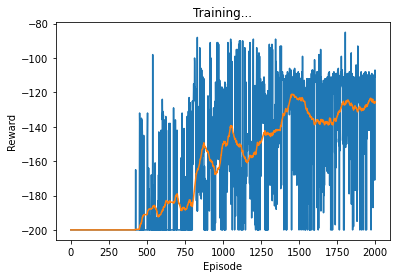

In [12]:
num_episodes = 2000
loss_t = []
reward_t = []
loss_ = False
for i_episode in range(num_episodes):
    state = env.reset()
    state = torch.from_numpy(state.reshape((-1, 2)).copy()).float()
    reward_acc = 0
    for t in count():
        accion = seleccionar_accion(state)
        next_state, reward, done, _ = env.step(accion.item())
        next_state = torch.from_numpy(next_state.reshape((-1, 2)).copy()).float()
        reward = torch.tensor([reward])
        reward_acc += reward.item()
        memory.push(state, accion, next_state, reward)
        state = next_state
        loss_ = optimize_model()
        if done:
            episode_durations.append(t + 1)
            loss_t.append(loss_)
            reward_t.append(reward_acc)
            plot_durations()
            break
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())